# **Customer Conversion Prediction Base Model**
This notebook is using Audio Books App. customer conversion data. The goal of this notebook is to create classification model that can predicts whether the customer will buy again (convert) or not.

## Dependencies

In [ ]:
# #install pycaret and downgrade scikit-learn
# !pip install scikit-learn==0.23.2
# !pip install pycaret[full]
# !pip list -v

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Exploration

Unfortunately, the data columns haven't been labeled, so we label them first.

In [ ]:
conversion = pd.read_csv('/content/drive/MyDrive/Course_Data/Audiobooks_data.csv',
              names = ['id', 'book_length_avg', 'book_length_overall', 'price_avg', 'price_overall', 'review', 'review_10/10', 'completion', 'minute_listened',
                       'support_req', 'last_visit_minus_purchase', 'target']) 

In [ ]:
conversion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14084 entries, 0 to 14083
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         14084 non-null  int64  
 1   book_length_avg            14084 non-null  float64
 2   book_length_overall        14084 non-null  int64  
 3   price_avg                  14084 non-null  float64
 4   price_overall              14084 non-null  float64
 5   review                     14084 non-null  int64  
 6   review_10/10               14084 non-null  float64
 7   completion                 14084 non-null  float64
 8   minute_listened            14084 non-null  float64
 9   support_req                14084 non-null  int64  
 10  last_visit_minus_purchase  14084 non-null  int64  
 11  target                     14084 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 1.3 MB


All the data is numeric and not contains any null values

In [ ]:
conversion.head()

,id,book_length_avg,book_length_overall,price_avg,price_overall,review,review_10/10,completion,minute_listened,support_req,last_visit_minus_purchase,target
0,873,2160.0,2160,10.13,10.13,0,8.91,0.0,0.0,0,0,1
1,611,1404.0,2808,6.66,13.33,1,6.50,0.0,0.0,0,182,1
2,705,324.0,324,10.13,10.13,1,9.00,0.0,0.0,1,334,1
3,391,1620.0,1620,15.31,15.31,0,9.00,0.0,0.0,0,183,1
4,819,432.0,1296,7.11,21.33,1,9.00,0.0,0.0,0,0,1


**Data Dictionary** <br>
`id` = Customer's id <br>
`book_length_overall` = Sum of the length of customer's book <br>
`book_length_avg` = Average length of customer's book <br>
`price_avg` = Average price of customer's book <br>
`price_overall` = Sum price of customer's book <br>
`review` = Customer's gave review or not <br>
`review_10/10` = Customer review's rating <br>
`minute_listened` = How many minute customer have listened to their book <br>
`completion` = Total minute_listened / total book length <br>
`support_req` = How many support request customer ask <br>
`last_visit_minus_purchase` = How many days are the interval between purchase date and latest visit date (bigger better)

In [ ]:
#check unique id
conversion['id'].nunique()

14084

Unlike purchase data, this data level of details seems laying on customers

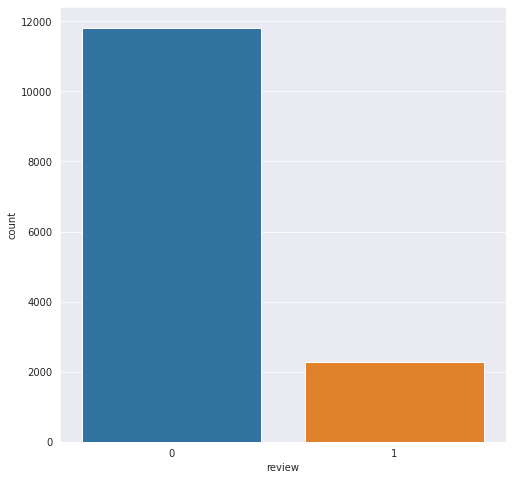

In [ ]:
#check review
sns.set_style('darkgrid')
plt.figure(figsize = (8,8))
sns.countplot(data = conversion, x = 'review')
plt.show()

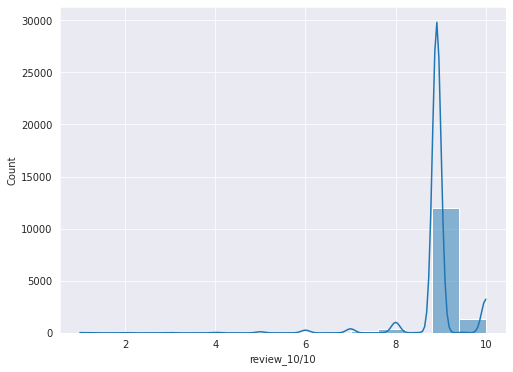

In [ ]:
#check review ratings
plt.figure(figsize = (8,6))
sns.histplot(conversion['review_10/10'], kde = True)
plt.show()

In [ ]:
conversion['review_10/10'].describe()

count    14084.000000
mean         8.909795
std          0.643406
min          1.000000
25%          8.910000
50%          8.910000
75%          8.910000
max         10.000000
Name: review_10/10, dtype: float64

In [ ]:
conversion['review_10/10'].value_counts().head()

8.91     11616
10.00     1284
8.00       404
9.00       381
7.00       157
Name: review_10/10, dtype: int64

In [ ]:
conversion[conversion['review_10/10'] == 8.91]['review'].value_counts()

0    11616
Name: review, dtype: int64

In [ ]:
rev = conversion['review_10/10'].replace(8.91, np.nan)
rev.mean()

8.908829011345217

It seems like the `8.91` (average) is the imputer for the customer who didn't give review 

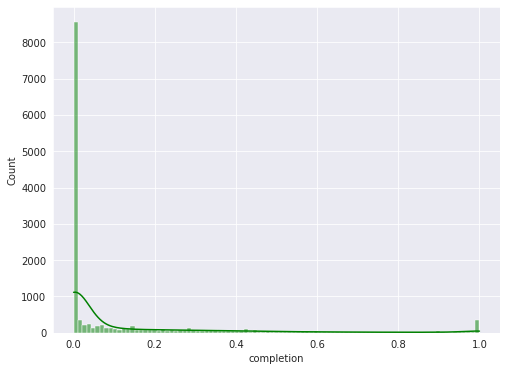

In [ ]:
#check completion
plt.figure(figsize = (8,6))
sns.histplot(conversion['completion'], kde = True, color = 'green')
plt.show()

In [ ]:
conversion['completion'].describe()

count    14084.000000
mean         0.125659
std          0.241206
min          0.000000
25%          0.000000
50%          0.000000
75%          0.130000
max          1.000000
Name: completion, dtype: float64

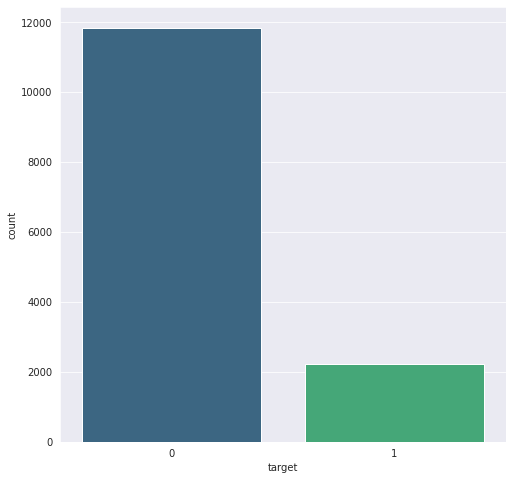

In [ ]:
#check label
plt.figure(figsize = (8,8))
sns.countplot(data = conversion, x = 'target', palette = 'viridis')
plt.show()

In [ ]:
#label proportion
conversion['target'].value_counts(normalize = True)*100

0    84.116728
1    15.883272
Name: target, dtype: float64

The target/label is imbalanced

## Data Balancing (Undersampling)

In [ ]:
#import imbalance-learn for sampling
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
sampler = RandomUnderSampler(random_state = 42)

In [ ]:
#define target and feature
feature =  conversion.drop(columns = ['id', 'target'])
target = conversion['target']

In [ ]:
#resample data using random undersampling
feature_res, target_res = sampler.fit_resample(feature, target)

In [ ]:
#re-count target
target_res.value_counts()

0    2237
1    2237
Name: target, dtype: int64

In [ ]:
#shape of resampled feature
feature_res.shape

(4474, 10)

The data is balanced

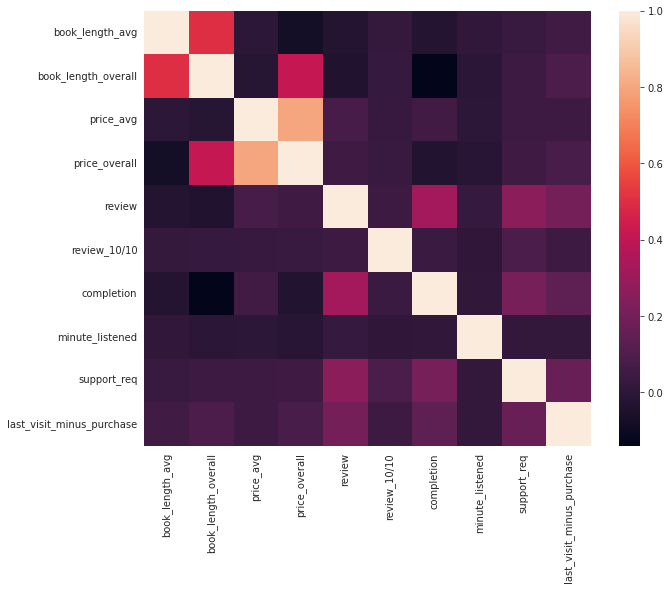

In [ ]:
#features correlation heatmap
plt.figure(figsize = (10,8))
sns.heatmap(feature_res.corr())
plt.show()

There is some significant correlation between `review` and `completion` and between `price_overall` and `book_length_overall`

In [ ]:
#create resampled new conversion dataframe
conversion_res = pd.concat([feature_res, target_res], axis = 1)

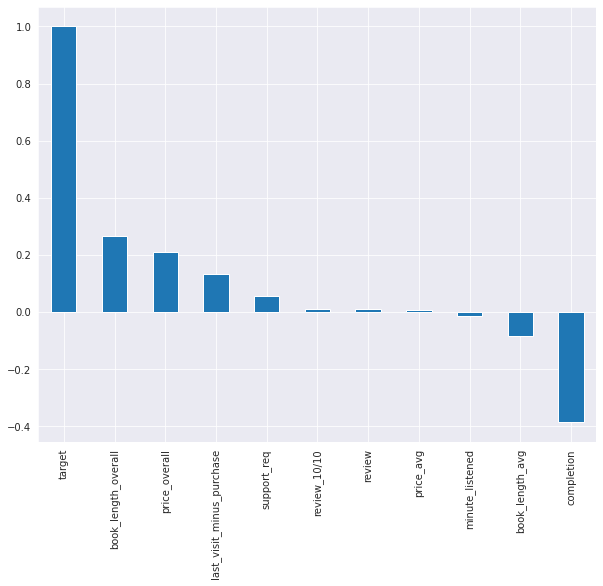

In [ ]:
#target correlation plot
plt.figure(figsize = (10,8))
conversion_res.corr()['target'].sort_values(ascending = False).plot(kind = 'bar')
plt.show()

`book_length_overall` and `completion` seems the most correlated features with target.

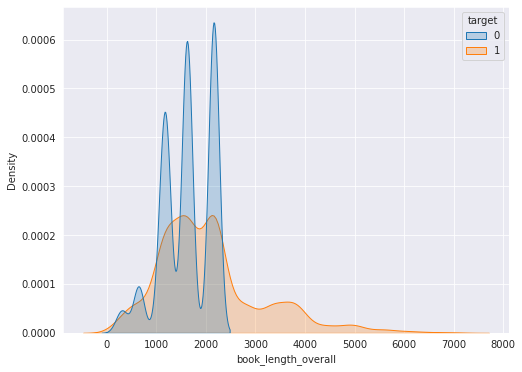

In [ ]:
#book length overall distribution 
plt.figure(figsize = (8,6))
sns.kdeplot(x = 'book_length_overall', data = conversion_res, hue = 'target', shade = True)
plt.xticks(np.linspace(0, 8000, 9))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


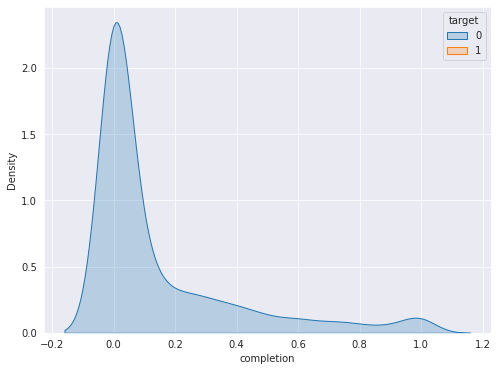

In [ ]:
#completion overall distribution 
plt.figure(figsize = (8,6))
sns.kdeplot(x = 'completion', data = conversion_res, hue = 'target', shade = True)
plt.show()

In [ ]:
#check completion for conversion customer from original data
conversion[conversion['target'] == 1]['completion'].value_counts()

0.0    2237
Name: completion, dtype: int64

In [ ]:
#check completion for non-conversion customer from original data
conversion[conversion['target'] == 0]['completion'].value_counts()

0.00    6058
0.02     347
0.01     257
0.04     247
0.03     224
        ... 
0.69       9
0.92       8
0.87       7
0.93       7
0.88       5
Name: completion, Length: 101, dtype: int64

This `completion` feature seems unnatural because all of the labeled "1" customers has 0 (zero) completion

## Feature Engineering

In [ ]:
#check if any negative
feature_res.describe()

,book_length_avg,book_length_overall,price_avg,price_overall,review,review_10/10,completion,minute_listened,support_req,last_visit_minus_purchase
count,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000
mean,1557.863044,1832.765311,7.234394,8.619544,0.167412,8.920451,0.073458,116.112794,0.079571,70.334600
std,493.462008,871.530542,5.194613,6.787664,0.373385,0.685299,0.191020,265.338427,0.430679,92.714949
min,216.000000,216.000000,3.860000,3.860000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1188.000000,1188.000000,5.330000,5.330000,0.000000,8.910000,0.000000,0.000000,0.000000,0.000000
50%,1620.000000,1620.000000,6.090000,6.930000,0.000000,8.910000,0.000000,0.000000,0.000000,19.000000
75%,2160.000000,2160.000000,8.000000,8.850000,0.000000,8.910000,0.000000,64.800000,0.000000,129.000000
max,2160.000000,7020.000000,104.000000,111.470000,1.000000,10.000000,1.000000,2116.800000,10.000000,383.000000


Since we'll work with various kinds of models, we will scaled the data. There is no negative values on the numerical features so `normalization`/ `min-max` scaling is preferred

In [ ]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_feature = pd.DataFrame(scaler.fit_transform(feature_res))
scaled_feature.columns = feature_res.columns
scaled_feature

,book_length_avg,book_length_overall,price_avg,price_overall,review,review_10/10,completion,minute_listened,support_req,last_visit_minus_purchase
0,0.722222,0.206349,0.014679,0.013660,0.0,0.878889,0.02,0.000000,0.0,0.018277
1,1.000000,0.285714,0.022768,0.021188,0.0,0.878889,0.09,0.329082,0.0,0.000000
2,1.000000,0.285714,0.062612,0.058266,0.0,0.878889,0.04,0.011224,0.0,0.159269
3,1.000000,0.285714,0.036749,0.034198,0.0,0.878889,0.02,0.000000,0.0,0.355091
4,0.500000,0.142857,0.014679,0.013660,0.0,0.878889,0.00,0.053571,0.0,0.052219
...,...,...,...,...,...,...,...,...,...,...
4469,0.722222,0.206349,0.014679,0.013660,0.0,0.878889,0.00,0.000000,0.0,0.000000
4470,0.648148,0.619048,0.014679,0.112815,0.0,0.878889,0.00,0.000000,0.0,0.000000
4471,1.000000,0.285714,0.014679,0.013660,0.0,0.878889,0.00,0.000000,0.0,0.031332
4472,1.000000,0.285714,0.014679,0.013660,1.0,1.000000,0.00,0.000000,0.0,0.015666


## Split Dataset

In [ ]:
#define X and y
X = scaled_feature
y = target_res

In [ ]:
#final dataframe
df = pd.concat([X,y], axis = 1)

## Model Building

In [ ]:
#import pycaret
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
#setup classifier
clf = setup(data = df, target = 'target') 

,Description,Value
0,session_id,5955
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4474, 11)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
#compare models
best_model = compare_models(fold = 5, turbo = False, include = ['ada', 'gbc', 'rf', 'xgboost', 'catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8282,0.9175,0.8181,0.8402,0.8287,0.6564,0.6570,0.372
catboost,CatBoost Classifier,0.8259,0.9183,0.8068,0.8444,0.8250,0.6521,0.6530,2.614
ada,Ada Boost Classifier,0.8247,0.9166,0.7942,0.8515,0.8217,0.6497,0.6514,1.510
xgboost,Extreme Gradient Boosting,0.8071,0.9086,0.7804,0.8304,0.8044,0.6145,0.6159,7.736
rf,Random Forest Classifier,0.7991,0.8981,0.7967,0.8066,0.8013,0.5982,0.5986,0.802


## Gradient Boosting Model

In [ ]:
gb = create_model('gbc', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8217,0.9036,0.7562,0.8768,0.8121,0.6441,0.6505
1,0.8019,0.9147,0.7875,0.8182,0.8025,0.6040,0.6044
2,0.8594,0.9413,0.8625,0.8625,0.8625,0.7187,0.7187
3,0.8722,0.9300,0.8625,0.8846,0.8734,0.7444,0.7447
4,0.8179,0.9009,0.8176,0.8228,0.8202,0.6357,0.6357
5,0.8307,0.9198,0.8113,0.8487,0.8296,0.6615,0.6622
6,0.8498,0.9331,0.8428,0.8590,0.8508,0.6997,0.6998
7,0.8051,0.8974,0.8113,0.8062,0.8088,0.6101,0.6101
8,0.8307,0.9239,0.8176,0.8442,0.8307,0.6614,0.6618
9,0.8083,0.9013,0.7987,0.8194,0.8089,0.6167,0.6169


In [ ]:
#auto-tune model
tuned_gb = tune_model(gb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8121,0.9129,0.7438,0.8686,0.8013,0.6251,0.6319
1,0.8083,0.9224,0.7875,0.8289,0.8077,0.6169,0.6177
2,0.8754,0.9446,0.8750,0.8805,0.8777,0.7507,0.7507
3,0.8754,0.9323,0.8625,0.8903,0.8762,0.7509,0.7512
4,0.8179,0.9026,0.8176,0.8228,0.8202,0.6357,0.6357
5,0.8339,0.9172,0.8176,0.8497,0.8333,0.6679,0.6683
6,0.8562,0.9315,0.8302,0.8800,0.8544,0.7127,0.7138
7,0.8019,0.9035,0.8050,0.8050,0.8050,0.6037,0.6037
8,0.8275,0.9227,0.8176,0.8387,0.8280,0.6550,0.6552
9,0.8019,0.9031,0.7925,0.8129,0.8025,0.6039,0.6041


In [ ]:
#print model 
print(tuned_gb)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=2,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.5, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=130,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5955, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## Model Evaluation

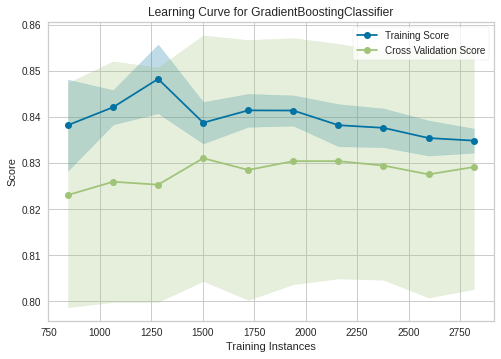

In [ ]:
#learning curve
plot_model(tuned_gb, plot = 'learning')

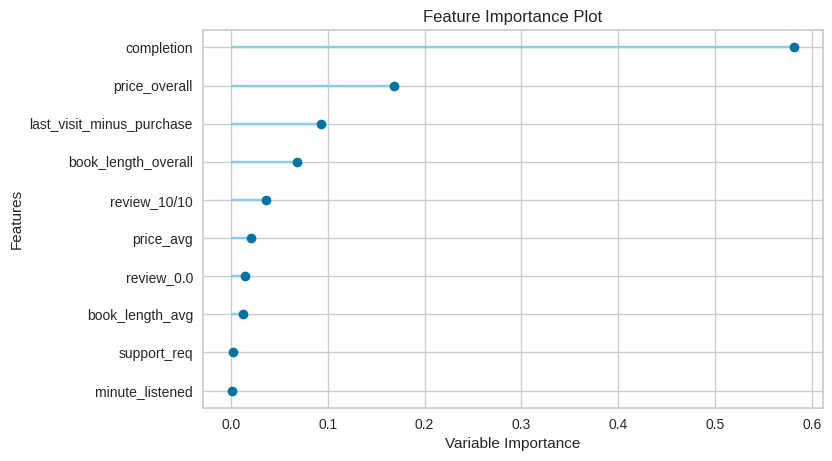

In [ ]:
#feature importance
plot_model(tuned_gb, plot = 'feature')

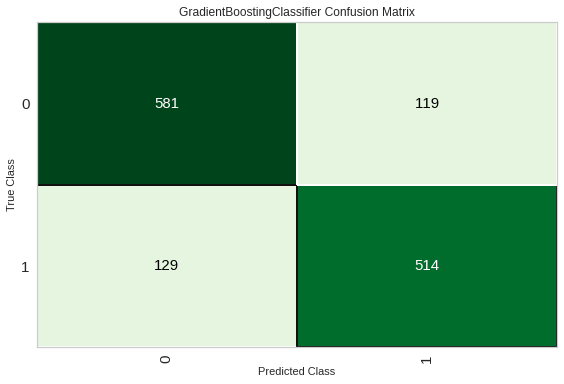

In [ ]:
#confusion matrix
plot_model(tuned_gb, plot = 'confusion_matrix')

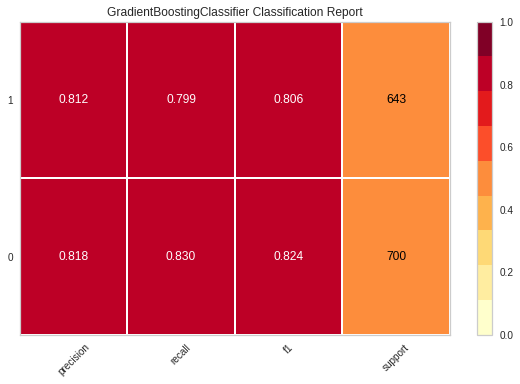

In [ ]:
#class report
plot_model(tuned_gb, plot = 'class_report')

## Oversampling Model

In [ ]:
#rescaling original data
scaled_feature2 = pd.DataFrame(scaler.fit_transform(feature))
scaled_feature2.columns = feature.columns
df2 = pd.concat([scaled_feature2, target], axis = 1)
df2

,book_length_avg,book_length_overall,price_avg,price_overall,review,review_10/10,completion,minute_listened,support_req,last_visit_minus_purchase,target
0,1.000000,0.285714,0.049339,0.049339,0.0,0.878889,0.00,0.0,0.000000,0.000000,1
1,0.611111,0.380952,0.022033,0.074520,1.0,0.611111,0.00,0.0,0.000000,0.392241,1
2,0.055556,0.015873,0.049339,0.049339,1.0,0.888889,0.00,0.0,0.033333,0.719828,1
3,0.722222,0.206349,0.090101,0.090101,0.0,0.888889,0.00,0.0,0.000000,0.394397,1
4,0.111111,0.158730,0.025574,0.137472,1.0,0.888889,0.00,0.0,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
14079,1.000000,0.285714,0.032499,0.032499,0.0,0.878889,0.00,0.0,0.000000,0.116379,0
14080,0.722222,0.206349,0.011568,0.011568,1.0,0.888889,0.61,0.0,0.000000,0.008621,0
14081,0.444444,0.126984,0.021168,0.021168,1.0,0.555556,0.29,0.0,0.000000,0.062500,0
14082,1.000000,0.285714,0.017941,0.017941,0.0,0.878889,0.00,0.0,0.000000,0.000000,0


In [ ]:
#setup clf
clf_over = setup(data = df2, target = 'target', fix_imbalance = True)

,Description,Value
0,session_id,7972
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(14084, 11)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
#comparing models
oversampling_model = compare_models(turbo = False, fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8822,0.8994,0.6480,0.6223,0.6348,0.5646,0.5649,0.388
catboost,CatBoost Classifier,0.8807,0.9053,0.6686,0.6123,0.6390,0.5677,0.5686,8.088
xgboost,Extreme Gradient Boosting,0.8792,0.8969,0.6249,0.6185,0.6213,0.5495,0.5497,5.308
rf,Random Forest Classifier,0.8642,0.8798,0.6474,0.5626,0.6012,0.5200,0.5223,1.358
svm,SVM - Linear Kernel,0.8630,0.0000,0.6249,0.5610,0.5901,0.5082,0.5101,0.130
dt,Decision Tree Classifier,0.8628,0.7897,0.6249,0.5617,0.5908,0.5088,0.5103,0.108
et,Extra Trees Classifier,0.8600,0.8533,0.6249,0.5517,0.5853,0.5016,0.5035,1.156
gbc,Gradient Boosting Classifier,0.8465,0.9133,0.7765,0.5092,0.6150,0.5242,0.5426,1.330
ada,Ada Boost Classifier,0.8452,0.9127,0.7797,0.5065,0.6141,0.5226,0.5417,0.476
lr,Logistic Regression,0.8450,0.8860,0.6943,0.5074,0.5861,0.4936,0.5030,1.408


In [ ]:
oversampling_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7972, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)